### Итоговая работа
### 12448/1 ИНЖДАН МГТУ им. Н.Э. Баумана
### Инженер данных (Data engineer)
### Андреев Андрей Анатольевич

## КЛАССИФИКАЦИЯ ГОСКОНТРАКТОВ ПО ОБЪЕКТАМ ЗАКУПКИ

#### Задача: необходимо на основе данных с ftp.zakupki.gov.ru научиться определять группу, к которой относится контракт с кодом ОКПД-2 41, 42, 43, 71.1.

Группы могут быть следующими:

1.	Строительно-монтажные работы (СМР)
2.	Проектно-изыскательские работы (ПИР)
3.	Строительный надзор
4.	Подключение коммуникаций
5.	Прочее.

По ОКПД-2 контракты в общем случае должны разделяться так:
- Строительно-монтажные работы (СМР) - 41, 42, 43(кроме нижеперечисленных)
- Проектно-изыскательские работы (ПИР) - 41.1, 71.1
- Подключение коммуникаций - 43.22
- Строительный надзор – четкой группы нет.


Проблема: Далеко не всегда контракты указываются с нужным кодом, поэтому есть проблема как такие контракты "отловить" и определить в нужную группу.

Поэтому задача предполагает классификацию контрактов на основе объекта закупки, который сформулирован естественным языком. Также предполагаем, что могут иметь значение цена контракта и его длительность.
На основе этого на входе данные о контрактах. На выходе необходимо получить группу для каждого контракта.

Иногда контракт может относиться одновременно в несколько групп.

В приложении ниже пример нескольких контрактов, у которых неверно проставлен ОКПД-2.

# Шаг 4 - Построение модели классификатора

In [5]:
! pip install scikit-learn
! pip install nltk
#! pip install pymorphy2
! pip install requests
#! pip install gensim
#! pip install pymystem3
! pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [7]:
columns = ['object_name', 'object_code', 'cost', 'contract_execution_days']
dtypes = {'object_name': str,
          'object_code': str, 
          'cost':lambda x: pd.to_numeric(x, errors="coerce"), 
          'contract_execution_days': lambda x: pd.to_numeric(x, errors="coerce"),
          'cluster': int}

In [8]:
df = pd.read_csv('datasets/dataset_nlp.csv', sep=';', low_memory=False, on_bad_lines='skip')
df['object_name']  = df['object_name'].astype('string')
df['object_code']  = df['object_code'].astype('string')
df['price_per_day'] = df['cost'] / df['contract_execution_days']
df.shape

(900153, 9)

In [9]:
df.describe()

,id,contract_number,cost,contract_execution_days,price_per_day
count,9.001530e+05,9.001530e+05,9.001530e+05,900153.000000,9.001530e+05
mean,1.215062e+07,3.044760e+18,7.050218e+06,153.150148,4.646881e+04
std,7.133365e+06,6.505005e+17,1.685426e+08,146.767441,5.455776e+05
min,1.374390e+05,3.403001e+17,1.000000e-02,1.000000,1.024590e-05
25%,5.810018e+06,2.771570e+18,2.092741e+05,59.000000,2.055556e+03
50%,1.190011e+07,3.244301e+18,6.920000e+05,112.000000,7.254839e+03
75%,1.811065e+07,3.504601e+18,2.161987e+06,203.000000,2.390824e+04
max,2.719647e+07,4.920456e+18,1.387754e+11,2000.000000,2.649200e+08


In [10]:
df.head()

,id,contract_number,object_name,object_code,cost,contract_execution_days,data,data_final,price_per_day
0,137439,2590407717221000153,Работы строительные специализированные,43.9,539265.60,29,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",18595.365517
1,137528,2590421285821000134,Работы строительные специализированные,43.9,2299469.98,122,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",18848.114590
2,137529,2590421285821000135,Работы строительные специализированные,43.9,1898111.58,122,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",15558.291639
3,137827,2590500335021000676,Работы строительные специализированные,43.3,341914.00,199,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",1718.160804
4,138113,2590615606021000060,Услуги в области архитектуры и инженерно-техни...,71.1,1714352.37,383,"['услуги', 'в', 'области', 'архитектуры', 'и',...","['услуг', 'област', 'архитектур', 'проектирова...",4476.115849


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900153 entries, 0 to 900152
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       900153 non-null  int64  
 1   contract_number          900153 non-null  int64  
 2   object_name              900153 non-null  string 
 3   object_code              900153 non-null  string 
 4   cost                     900153 non-null  float64
 5   contract_execution_days  900153 non-null  int64  
 6   data                     900153 non-null  object 
 7   data_final               900153 non-null  object 
 8   price_per_day            900153 non-null  float64
dtypes: float64(2), int64(3), object(2), string(2)
memory usage: 61.8+ MB


In [12]:
#Делаем разбивку по группам на основании номеров ОКПД-2
import re 

def match(templ, value):
    try:
      return re.search(f'^{templ}.', value) 
    except Exception as e:
        print(f"{type(e).__name__}: {e}")
        return False
    
def get_group(value):    
    if (match('41', value) or match('42', value) or match('43', value)) and  value not in ('43.9', '42.9', '42.2', '43.2', '41.1', '71.1', '43.2'):  
        return 'Строительно-монтажные работы'
    elif value in ('41.1', '71.1'):  
        return 'Проектно-изыскательские работы'
    elif value in ('43.2'):  
        return 'Подключение коммуникаций'
    elif value in ('43.9', '42.9', '42.2'):  
        return 'Строительный надзор'
    else:
        return 'Прочие'

In [13]:
df['group'] = df['object_code'].apply(lambda x: get_group(x))
df.head()

,id,contract_number,object_name,object_code,cost,contract_execution_days,data,data_final,price_per_day,group
0,137439,2590407717221000153,Работы строительные специализированные,43.9,539265.60,29,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",18595.365517,Строительный надзор
1,137528,2590421285821000134,Работы строительные специализированные,43.9,2299469.98,122,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",18848.114590,Строительный надзор
2,137529,2590421285821000135,Работы строительные специализированные,43.9,1898111.58,122,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",15558.291639,Строительный надзор
3,137827,2590500335021000676,Работы строительные специализированные,43.3,341914.00,199,"['работы', 'строительные', 'специализированные']","['работ', 'строительн', 'специализирова']",1718.160804,Строительно-монтажные работы
4,138113,2590615606021000060,Услуги в области архитектуры и инженерно-техни...,71.1,1714352.37,383,"['услуги', 'в', 'области', 'архитектуры', 'и',...","['услуг', 'област', 'архитектур', 'проектирова...",4476.115849,Проектно-изыскательские работы


### LabelEncoder

In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['group'])
#y = label_encoder.fit_transform(df['object_code'])
y

array([3, 3, 3, ..., 2, 2, 2])

### OneHotEncoder

In [15]:
df_final = df.copy()

from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder()
data_new = onehotencoder.fit_transform(df_final['group'].values.astype('U').reshape(-1, 1))
columns = np.char.strip(onehotencoder.categories_[0].astype('U'))
df_one_hot_codes = pd.DataFrame(data_new.toarray(), columns=columns)
df_one_hot_codes.head(10)

,Подключение коммуникаций,Проектно-изыскательские работы,Строительно-монтажные работы,Строительный надзор
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,1.0
8,0.0,0.0,0.0,1.0
9,0.0,0.0,0.0,1.0


По ОКПД-2 контракты в общем случае должны разделяться так:

0. Прочие
1. Строительно-монтажные работы (СМР) - 41, 42, 43(кроме нижеперечисленных)
2. Проектно-изыскательские работы (ПИР) - 41.1, 71.1
3. Подключение коммуникаций - 43.22
4. Строительный надзор – четкой группы нет. 

Строительный надзор - (43.9, 42.9, 42.2) - получил на основе ручного анализа данных. Лучше всего воспользоваться специалистом в этой предметной области.


### TfidfVectorizer

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

tfidf = TfidfVectorizer(max_features=1700, min_df=5, max_df=0.7)

X = df['data_final']
tfidf_X = tfidf.fit_transform(X).toarray()

tfidf_X
tfidf = pd.DataFrame(tfidf_X)
tfidf['price'] = df['price_per_day'].values
#tfidf['y'] = y
tfidf = tfidf.join(df_one_hot_codes)
tfidf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,price,Подключение коммуникаций,Проектно-изыскательские работы,Строительно-монтажные работы,Строительный надзор
0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,18595.365517,0.0,0.0,0.0,1.0
1,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,18848.114590,0.0,0.0,0.0,1.0
2,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,15558.291639,0.0,0.0,0.0,1.0
3,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1718.160804,0.0,0.0,1.0,0.0
4,0.368093,0.368093,0.0,0.000000,0.0,0.368093,0.368093,0.227048,0.368093,0.000000,0.0,0.000000,0.368093,0.368093,4476.115849,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900148,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,8877.311896,0.0,0.0,1.0,0.0
900149,0.000000,0.000000,0.0,0.521427,0.0,0.000000,0.000000,0.429351,0.000000,0.521427,0.0,0.521427,0.000000,0.000000,382406.279305,0.0,0.0,1.0,0.0
900150,0.000000,0.000000,0.0,0.521427,0.0,0.000000,0.000000,0.429351,0.000000,0.521427,0.0,0.521427,0.000000,0.000000,310671.686631,0.0,0.0,1.0,0.0
900151,0.000000,0.000000,0.0,0.521427,0.0,0.000000,0.000000,0.429351,0.000000,0.521427,0.0,0.521427,0.000000,0.000000,105351.878211,0.0,0.0,1.0,0.0


In [17]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaler.fit(tfidf.values)
X_train_scaled = scaler.transform(tfidf.values)
X_train_scaled


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

# Кластеризация MiniBatchKMeans

In [18]:
from sklearn.cluster import MiniBatchKMeans

#X = df_vectors.values
X = X_train_scaled
kmeans = MiniBatchKMeans(n_clusters=4, random_state=0, batch_size=1000, max_iter=10, n_init="auto").fit(X)
kmeans.cluster_centers_

array([[0.00000000e+00, 0.00000000e+00, 4.59190445e-01, 0.00000000e+00,
        4.59190445e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 5.40809555e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.61030580e-04, 0.00000000e+00,
        2.98606503e-02, 9.52886530e-01, 1.72528202e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.91402231e-04, 0.00000000e+00,
        0.00000000e+00, 6.94792537e-01, 3.05207463e-01],
       [1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 5.28817615e-01,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 7.41660582e-05, 0.00000000e+00,
        1.00000000e+00

In [19]:
df_cluster = df[['object_name', 'object_code', 'cost', 'contract_execution_days', 'group']].copy()
df_cluster['cluster'] = kmeans.labels_
df_cluster.head(100)

,object_name,object_code,cost,contract_execution_days,group,cluster
0,Работы строительные специализированные,43.9,539265.60,29,Строительный надзор,3
1,Работы строительные специализированные,43.9,2299469.98,122,Строительный надзор,3
2,Работы строительные специализированные,43.9,1898111.58,122,Строительный надзор,3
3,Работы строительные специализированные,43.3,341914.00,199,Строительно-монтажные работы,0
4,Услуги в области архитектуры и инженерно-техни...,71.1,1714352.37,383,Проектно-изыскательские работы,2
...,...,...,...,...,...,...
95,Работы строительные специализированные,43.2,2261673.60,18,Подключение коммуникаций,3
96,Работы строительные специализированные,43.3,349851.95,24,Строительно-монтажные работы,0
97,Работы строительные специализированные,43.2,258000.00,395,Подключение коммуникаций,3
98,Работы строительные специализированные,43.2,1740891.56,18,Подключение коммуникаций,3


In [20]:
df_cluster['cluster'].value_counts()

cluster
3    280407
1    268637
0    222930
2    128179
Name: count, dtype: int64

<Axes: >

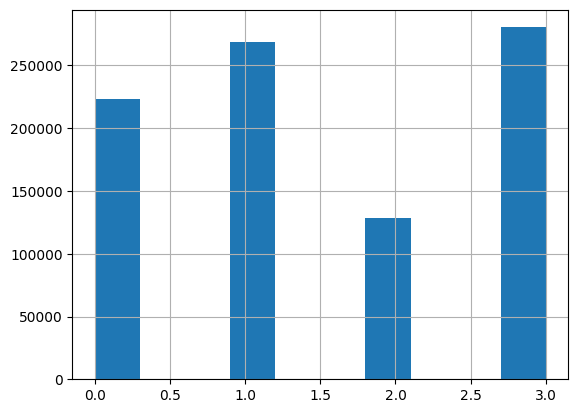

In [21]:
df_cluster['cluster'].hist()

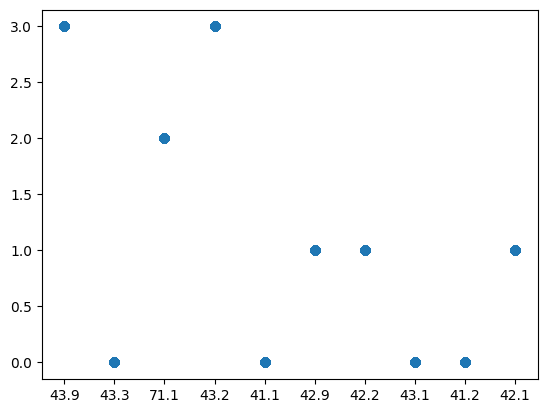

In [22]:
import matplotlib.pyplot as plt

plt.scatter(df_cluster['object_code'], df_cluster['cluster']) 
plt.show()

По ОКПД-2 контракты в общем случае должны разделяться так:

1. Строительно-монтажные работы (СМР) - 41, 42, 43(кроме нижеперечисленных)
2. Проектно-изыскательские работы (ПИР) - 41.1, 71.1
3. Подключение коммуникаций - 43.22
4. Строительный надзор – четкой группы нет. 

Строительный надзор - (43.9, 42.9, 42.2, 43.2) - получил на основе ручного анализа данных. Лучше всего воспользоваться специалистом в этой предметной области.


In [23]:
clusters = df_cluster['cluster'].unique()

comparisons = {}
for cluster in  clusters:
    codes = df_cluster[df_cluster['cluster']==cluster].groupby(['object_code']).count()['object_name']
    comparisons[cluster] = codes.index

comparisons



{3: Index(['43.2', '43.9'], dtype='string', name='object_code'),
 0: Index(['41.1', '41.2', '43.1', '43.3'], dtype='string', name='object_code'),
 2: Index(['71.1'], dtype='string', name='object_code'),
 1: Index(['42.1', '42.2', '42.9'], dtype='string', name='object_code')}

In [24]:
def get_group(x):
    for key, value in comparisons.items():
        #print(x, value)
        if x in value:            
            return key
    return 0

#df_cluster['group'] = df_cluster['object_code'].apply(lambda x: get_group(x))
#df_cluster.head()

In [25]:
groups = {1:{'code':['43.1', '43.2', '43.3', '43.9'], 'name':'Строительно-монтажные работы'},
               2:{'code': ['41.1', '71.1'], 'name':'Проектно-изыскательские работы'},
               3:{'code': ['43.22'], 'name':'Подключение коммуникаций'},
               4:{'code': ['43.9', '42.9', '42.2', '43.2'], 'name':'Строительный надзор'},
              }
def get_cluster_name(x):
    return groups[x]['name']

#df_cluster['cluster_name'] =  df_cluster['cluster'].apply(lambda x: get_cluster_name(x) )

In [26]:
df_cluster.groupby(['group','cluster', 'object_code'])['object_name'].count() 

group                           cluster  object_code
Подключение коммуникаций        3        43.2           166377
Проектно-изыскательские работы  0        41.1             7203
                                2        71.1           128179
Строительно-монтажные работы    0        41.2            94237
                                         43.1            20794
                                         43.3           100696
                                1        42.1           185144
Строительный надзор             1        42.2            30753
                                         42.9            52740
                                3        43.9           114030
Name: object_name, dtype: int64

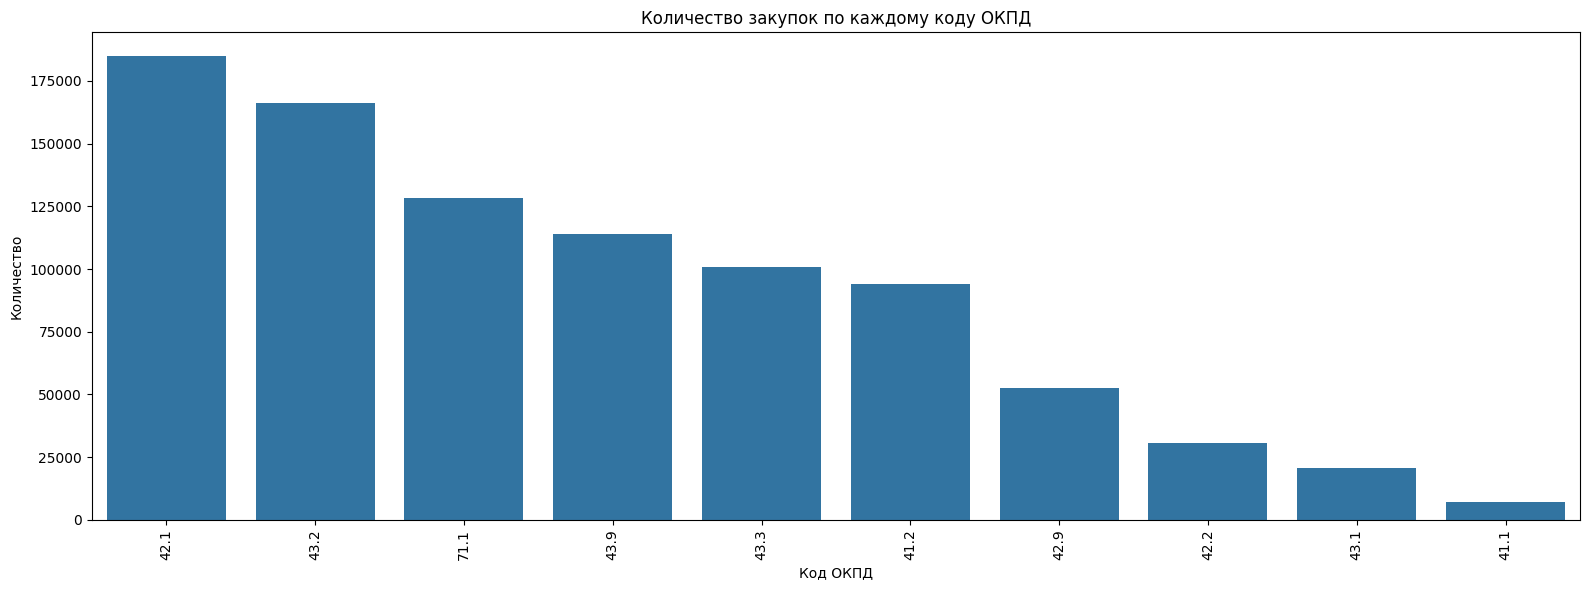

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
sns.countplot(data=df_cluster, x='object_code', order=df_cluster['object_code'].value_counts().index)
plt.title('Количество закупок по каждому коду ОКПД')
plt.xlabel('Код ОКПД')
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

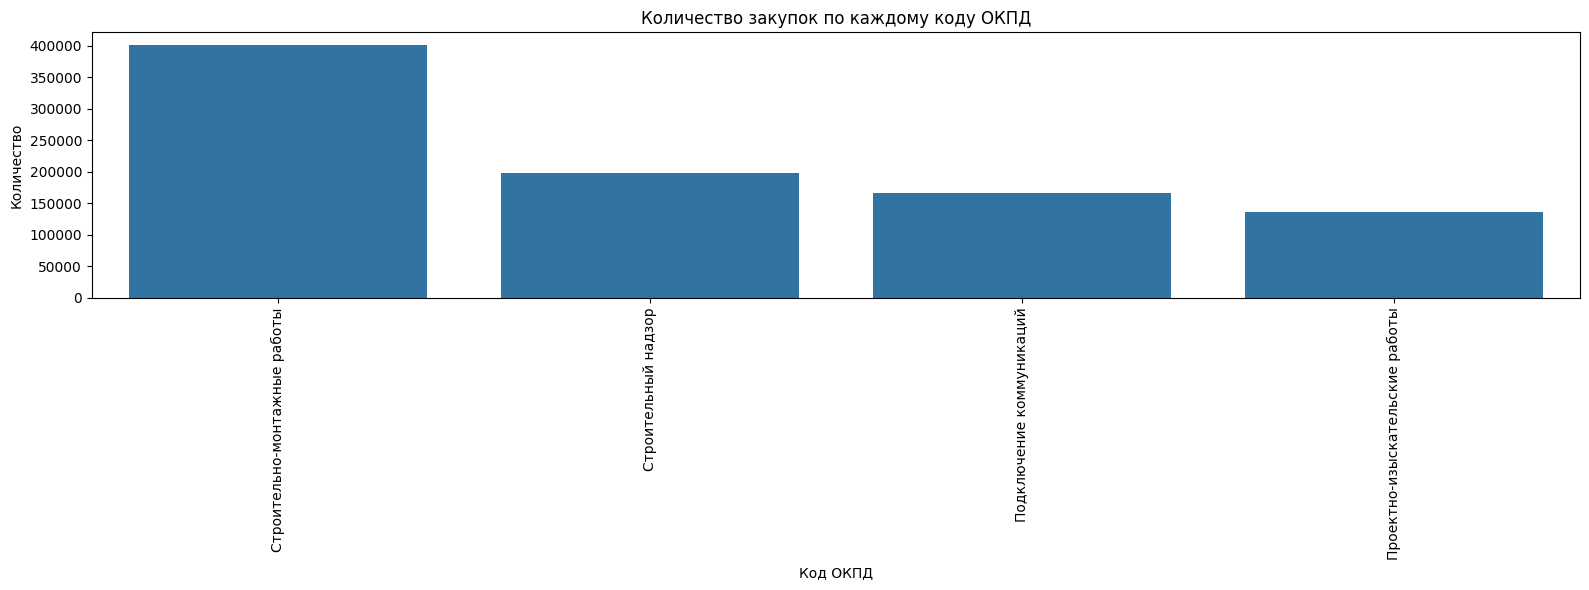

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
sns.countplot(data=df_cluster, x='group', order=df_cluster['group'].value_counts().index)
plt.title('Количество закупок по каждому коду ОКПД')
plt.xlabel('Код ОКПД')
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [29]:
grouped_data_int = df_cluster.groupby('cluster').agg(
    max_price=('cost', 'max'),
    avg_price=('cost', 'mean'),
    min_price=('cost', 'min'),
    max_duration=('contract_execution_days', 'max'),
    avg_duration=('contract_execution_days', 'mean'),
    min_duration=('contract_execution_days', 'min')).reset_index()
grouped_data_int

,cluster,max_price,avg_price,min_price,max_duration,avg_duration,min_duration
0,0,3.573493e+10,6.849354e+06,0.01,1978,134.467268,1
1,1,1.387754e+11,1.438522e+07,0.01,1987,153.580959,1
2,2,6.943426e+09,2.739999e+06,0.01,2000,200.120776,1
3,3,3.573347e+09,2.153070e+06,0.01,1993,146.119633,1


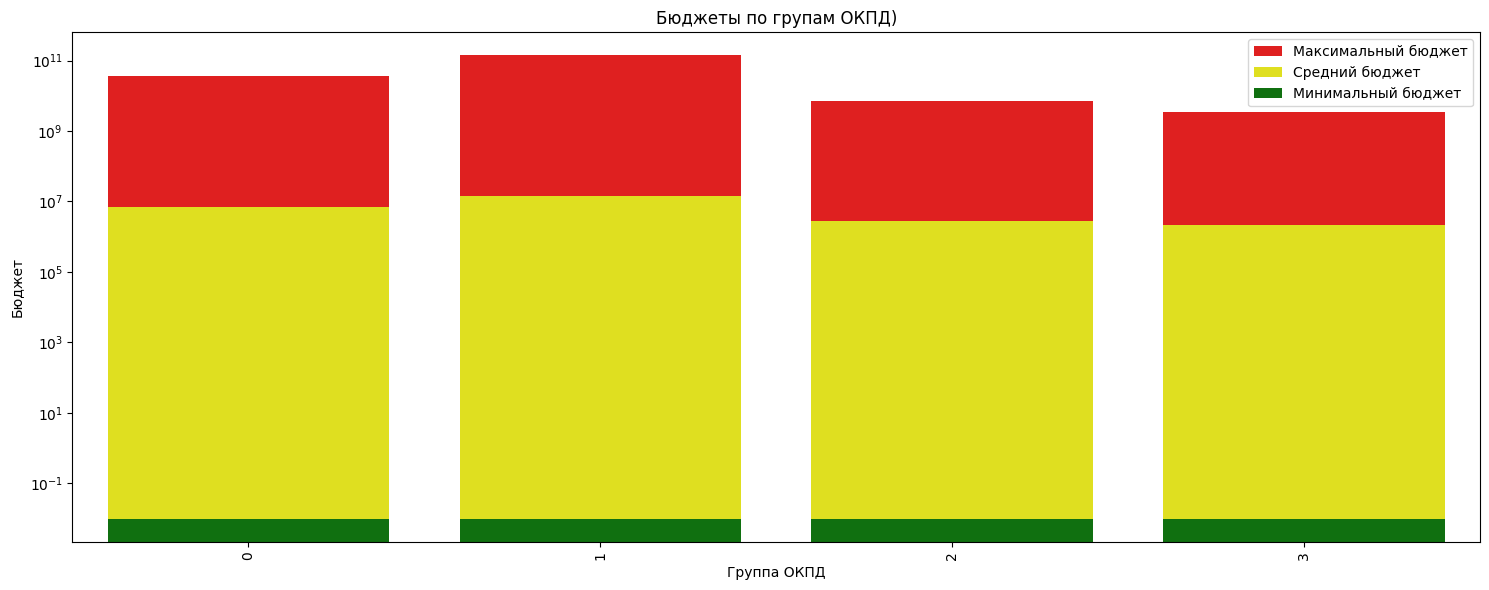

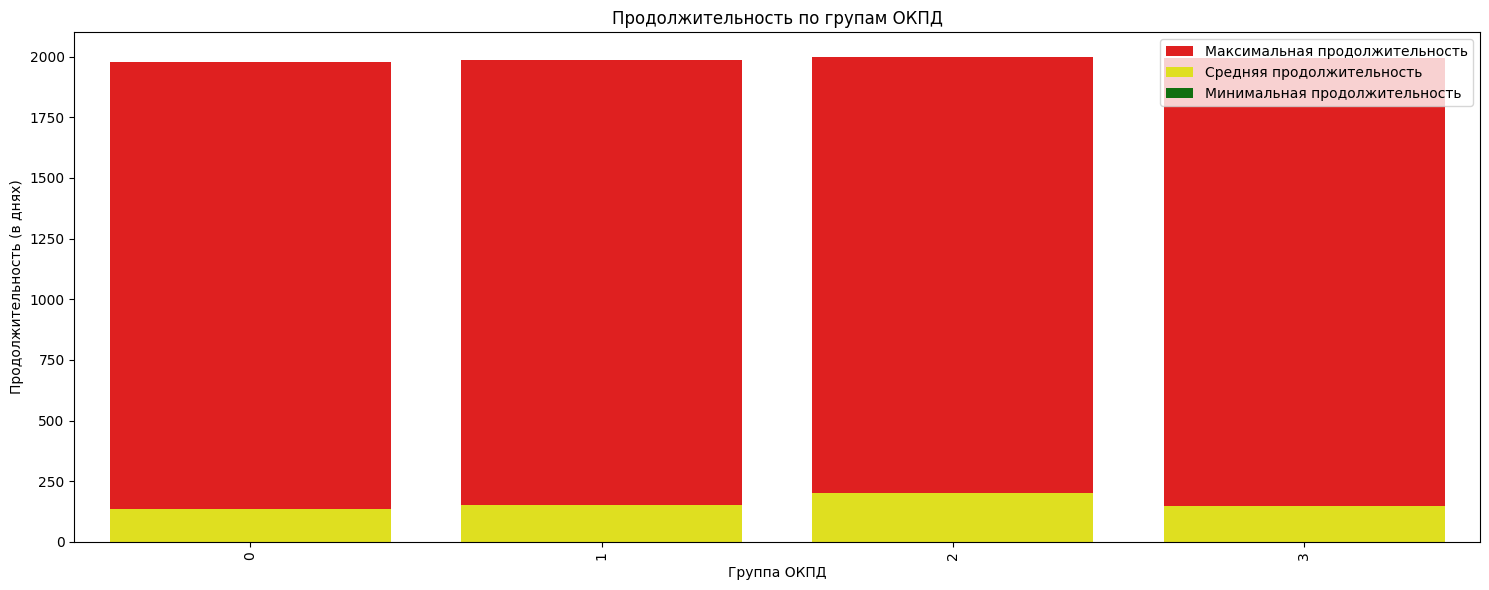

In [30]:
plt.figure(figsize=(15, 6))
sns.barplot(data=grouped_data_int, x='cluster', y='max_price', color='red', label='Максимальный бюджет')
sns.barplot(data=grouped_data_int, x='cluster', y='avg_price', color='yellow', label='Средний бюджет')
sns.barplot(data=grouped_data_int, x='cluster', y='min_price', color='green', label='Минимальный бюджет')
plt.title('Бюджеты по групам ОКПД)')
plt.xlabel('Группа ОКПД')
plt.ylabel('Бюджет')
plt.legend()
plt.xticks(rotation=90)
plt.yscale("log")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
sns.barplot(data=grouped_data_int, x='cluster', y='max_duration', color='red', label='Максимальная продолжительность')
sns.barplot(data=grouped_data_int, x='cluster', y='avg_duration', color='yellow', label='Средняя продолжительность')
sns.barplot(data=grouped_data_int, x='cluster', y='min_duration', color='green', label='Минимальная продолжительность')
plt.title('Продолжительность по групам ОКПД')
plt.xlabel('Группа ОКПД')
plt.ylabel('Продолжительность (в днях)')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [31]:
df_cluster.shape

(900153, 6)

In [32]:
df_cluster.to_csv('datasets/dataset_cluster.csv', sep=';', index=False)

### Классификация контрактов по разметке полученых с помощью кластеризации

In [33]:
df_cluster

,object_name,object_code,cost,contract_execution_days,group,cluster
0,Работы строительные специализированные,43.9,5.392656e+05,29,Строительный надзор,3
1,Работы строительные специализированные,43.9,2.299470e+06,122,Строительный надзор,3
2,Работы строительные специализированные,43.9,1.898112e+06,122,Строительный надзор,3
3,Работы строительные специализированные,43.3,3.419140e+05,199,Строительно-монтажные работы,0
4,Услуги в области архитектуры и инженерно-техни...,71.1,1.714352e+06,383,Проектно-изыскательские работы,2
...,...,...,...,...,...,...
900148,Работы строительные специализированные,43.3,1.873113e+06,211,Строительно-монтажные работы,0
900149,Сооружения и строительные работы в области гра...,42.1,1.430199e+08,374,Строительно-монтажные работы,1
900150,Сооружения и строительные работы в области гра...,42.1,1.161912e+08,374,Строительно-монтажные работы,1
900151,Сооружения и строительные работы в области гра...,42.1,7.774969e+07,738,Строительно-монтажные работы,1


In [34]:
X = df_cluster['object_name']
y = df_cluster['cluster']

In [35]:
from sklearn.model_selection import train_test_split
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)

(630107,) (270046,)


In [36]:
from sklearn.pipeline import Pipeline
# pipeline позволяет объединить в один блок трансформер и модель, что упрощает написание кода и улучшает его читаемость
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizer преобразует тексты в числовые вектора, отражающие важность использования каждого слова из некоторого набора слов (количество слов набора определяет размерность вектора) в каждом тексте
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
# линейный классификатор и классификатор методом ближайших соседей
from sklearn import metrics
# набор метрик для оценки качества модели
from sklearn.model_selection import GridSearchCV
# модуль поиска по сетке параметров

from sklearn.metrics import confusion_matrix

Создадим классификатор, без учета стоимости и длительности контракта и обучим их на тестовых данных:

In [37]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd_clf', SGDClassifier(random_state=42))])
sgd_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('sgd_clf', SGDClassifier(random_state=42))])

In [38]:
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

           0       0.45      1.00      0.63     30227
           1       1.00      1.00      1.00     80919
           2       1.00      1.00      1.00     38329
           3       1.00      0.70      0.82    120571

    accuracy                           0.87    270046
   macro avg       0.86      0.92      0.86    270046
weighted avg       0.94      0.87      0.88    270046



In [39]:
confusion_matrix(predicted_sgd, y_test)

array([[30227,     0,     0,     0],
       [    0, 80919,     0,     0],
       [    0,     0, 38329,     0],
       [36271,     0,     0, 84300]], dtype=int64)

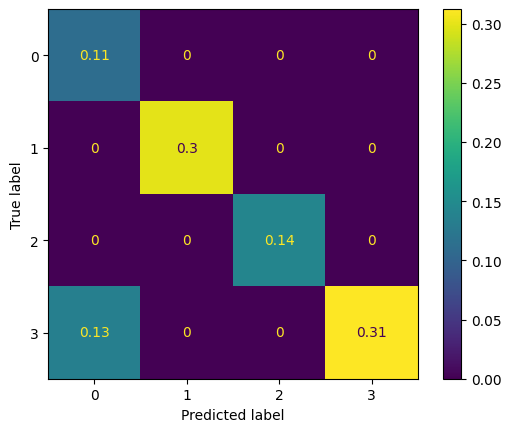

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(predicted_sgd, y_test, normalize='all')
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

### Построим нейронную сеть для классификации групп с учетом стоимости и длительносим контракта 

In [41]:
df_cls = df[['object_name', 'object_code', 'cost', 'contract_execution_days', 'group', 'price_per_day', 'data_final']].copy()
df_cls['cluster'] = kmeans.labels_
df_cls.head(100)

,object_name,object_code,cost,contract_execution_days,group,price_per_day,data_final,cluster
0,Работы строительные специализированные,43.9,539265.60,29,Строительный надзор,18595.365517,"['работ', 'строительн', 'специализирова']",3
1,Работы строительные специализированные,43.9,2299469.98,122,Строительный надзор,18848.114590,"['работ', 'строительн', 'специализирова']",3
2,Работы строительные специализированные,43.9,1898111.58,122,Строительный надзор,15558.291639,"['работ', 'строительн', 'специализирова']",3
3,Работы строительные специализированные,43.3,341914.00,199,Строительно-монтажные работы,1718.160804,"['работ', 'строительн', 'специализирова']",0
4,Услуги в области архитектуры и инженерно-техни...,71.1,1714352.37,383,Проектно-изыскательские работы,4476.115849,"['услуг', 'област', 'архитектур', 'проектирова...",2
...,...,...,...,...,...,...,...,...
95,Работы строительные специализированные,43.2,2261673.60,18,Подключение коммуникаций,125648.533333,"['работ', 'строительн', 'специализирова']",3
96,Работы строительные специализированные,43.3,349851.95,24,Строительно-монтажные работы,14577.164583,"['работ', 'строительн', 'специализирова']",0
97,Работы строительные специализированные,43.2,258000.00,395,Подключение коммуникаций,653.164557,"['работ', 'строительн', 'специализирова']",3
98,Работы строительные специализированные,43.2,1740891.56,18,Подключение коммуникаций,96716.197778,"['работ', 'строительн', 'специализирова']",3


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

tfidf = TfidfVectorizer(max_features=1700, min_df=5, max_df=0.7)

y = df_cls['cluster']
X = df_cls['data_final']
tfidf_X = tfidf.fit_transform(X).toarray()
tfidf = pd.DataFrame(tfidf_X)
tfidf['price'] = df_cls['price_per_day']
tfidf.shape

(900153, 15)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(tfidf.values, y, test_size=0.3)
print(X_train.shape, X_test.shape)

(630107, 15) (270046, 15)


In [44]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaler.fit(tfidf.values)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [45]:
import tensorflow as tf
tf.random.set_seed(1)
model_nn = tf.keras.Sequential([
tf.keras.layers.Dense(15, activation='sigmoid',name='fc1', input_shape=(15,)),
tf.keras.layers.Dense(30, activation='sigmoid',name='fc3', input_shape=(15,)),
tf.keras.layers.Dense(4, name='fc4', activation='softmax')])
model_nn.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 15)                240       
                                                                 
 fc3 (Dense)                 (None, 30)                480       
                                                                 
 fc4 (Dense)                 (None, 4)                 124       
                                                                 
Total params: 844 (3.30 KB)
Trainable params: 844 (3.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
model_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [47]:
import numpy as np
num_epochs = 10
history = model_nn.fit(X_train_scaled, y_train, epochs=num_epochs,  verbose=1)

Epoch 1/10
19691/19691 [==============================] - 14s 691us/step - loss: 0.2928 - accuracy: 0.8616
Epoch 2/10
19691/19691 [==============================] - 14s 698us/step - loss: 0.2743 - accuracy: 0.8649
Epoch 3/10
19691/19691 [==============================] - 14s 697us/step - loss: 0.2741 - accuracy: 0.8649
Epoch 4/10
19691/19691 [==============================] - 14s 698us/step - loss: 0.2740 - accuracy: 0.8649
Epoch 5/10
19691/19691 [==============================] - 14s 694us/step - loss: 0.2740 - accuracy: 0.8649
Epoch 6/10
19691/19691 [==============================] - 14s 697us/step - loss: 0.2739 - accuracy: 0.8649
Epoch 7/10
19691/19691 [==============================] - 14s 704us/step - loss: 0.2739 - accuracy: 0.8649
Epoch 8/10
19691/19691 [==============================] - 14s 695us/step - loss: 0.2739 - accuracy: 0.8649
Epoch 9/10
19691/19691 [==============================] - 14s 700us/step - loss: 0.2739 - accuracy: 0.8649
Epoch 10/10
19691/19691 [============

In [48]:
results = model_nn.evaluate(X_test_scaled, y_test, verbose=1)
print('Test loss: {:.4f} Test Acc.: {:.4f}'.format(*results))

8439/8439 [==============================] - 5s 626us/step - loss: 0.2746 - accuracy: 0.8654
Test loss: 0.2746 Test Acc.: 0.8654


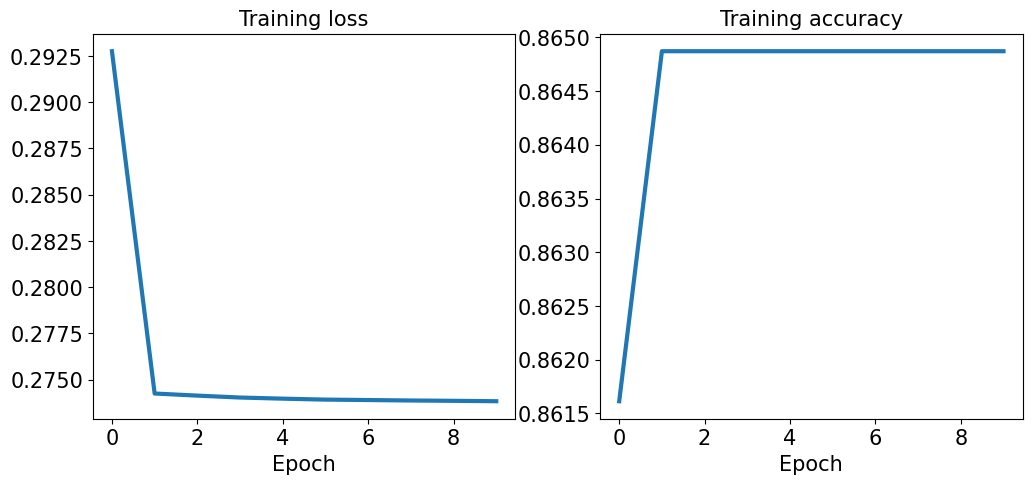

In [49]:
import matplotlib.pyplot as plt
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

### CatBoost

In [50]:
! pip install catboost


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
from catboost import CatBoostClassifier

In [ ]:
X = ['x', 'y', 'z', 'pressure', 'grip_angle', 'timestamp', 'test_id']
#X = ['x', 'y', 'z', 'pressure', 'grip_angle',  'test_id']
y = ['class']

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf.values, y, test_size=0.3)
print(X_train.shape, X_test.shape)

(630107, 15) (270046, 15)


In [57]:
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5)
print(X_valid.shape, X_test.shape)

(135023, 15) (135023, 15)


In [60]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=1000,
    random_seed=43,
)

In [64]:
model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    verbose=100,
)

Learning rate set to 0.122833
0:	learn: 1.1262894	test: 1.1263243	best: 1.1263243 (0)	total: 238ms	remaining: 3m 58s
100:	learn: 0.2653927	test: 0.2658689	best: 0.2658688 (99)	total: 7.84s	remaining: 1m 9s
200:	learn: 0.2652988	test: 0.2658656	best: 0.2658542 (122)	total: 16.1s	remaining: 1m 3s
300:	learn: 0.2652664	test: 0.2658771	best: 0.2658542 (122)	total: 24.4s	remaining: 56.8s
400:	learn: 0.2652481	test: 0.2658925	best: 0.2658542 (122)	total: 32.9s	remaining: 49.1s
500:	learn: 0.2652367	test: 0.2659048	best: 0.2658542 (122)	total: 41.2s	remaining: 41.1s
600:	learn: 0.2652281	test: 0.2659189	best: 0.2658542 (122)	total: 49.7s	remaining: 33s
700:	learn: 0.2652233	test: 0.2659267	best: 0.2658542 (122)	total: 58.1s	remaining: 24.8s
800:	learn: 0.2652181	test: 0.2659323	best: 0.2658542 (122)	total: 1m 6s	remaining: 16.5s
900:	learn: 0.2652146	test: 0.2659395	best: 0.2658542 (122)	total: 1m 14s	remaining: 8.21s
999:	learn: 0.2652116	test: 0.2659442	best: 0.2658542 (122)	total: 1m 22s	r

In [65]:
model.score(X_test, y_test)

0.864941528480333

In [66]:
y_pred = model.predict(X_test)

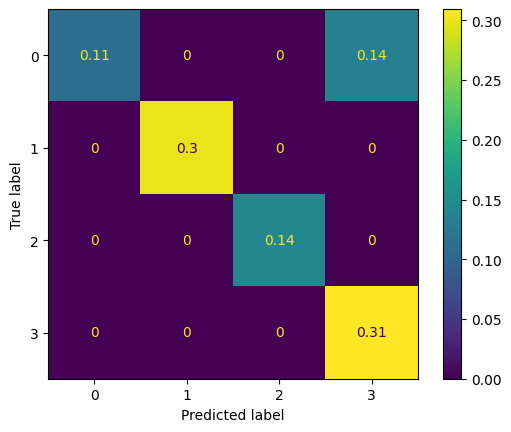

In [69]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='all'))
disp.plot()

### Логистическая регрессия

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix

grid = {"C": np.logspace(-3, 3, 7), "penalty": ["l1", "l2", "elasticnet"]}
grid
X_train_scaled

array([[1.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 7.39433191e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.75563853e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.32734969e-05],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.17076850e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.13228974e-05],
       [1.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 7.34602063e-04]])

In [77]:
model_lr = LogisticRegression(multi_class='ovr', C=4, penalty='l1', solver='liblinear')
search_model = GridSearchCV(model_lr, grid, cv=10)
search_model.fit(X_train_scaled, y_train)

In [73]:
search_model.best_params_

{'C': 0.01, 'penalty': 'l1'}

In [74]:
model = search_model.best_estimator_
model.fit(X_train_scaled, y_train)

LogisticRegression(C=0.01, multi_class='ovr', penalty='l1', solver='liblinear')

In [75]:
y_pred = model.predict(X_test_scaled)

In [76]:
model.score(X_test_scaled, y_test)

ValueError: Found input variables with inconsistent numbers of samples: [135023, 270046]

In [ ]:
confusion_matrix(y_pred, y_test)